### Trabajo Práctico - Visión por Computadora 2

### Integrantes: 
Martín, Matías. 

Querales, Gabriel.

Rodríguez, Joaquín.

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

### Dataset elegido - Plantvillage Dataset (Kaggle)

Consigna: 

*Entrenar un modelo que identifique y clasifique enfermedades en plantas a partir de imágenes, ayudando a los agricultores a tomar medidas preventivas y reducir pérdidas.​*

Elegimos para este TP crear un modelo para que detecte la **podredumbre negra** en plantas de **vid**. 

### 1. EDA

El dataset está organizado en una estructura de carpetas que sigue el formato de clasificación supervisada de imágenes donde el nombre de cada carpeta funciona como etiqueta para todas las imágenes que contiene. 

En un primer nivel contiene tres carpetas, la carpeta "color" posee las imágenes originales a color y las otras dos corresponden a data augmentation a partir de esa carpeta. La carpeta "grayscale" posee las mismas imágenes pero en blanco y negro y en la carpeta "segmented" están las imágenes a color pero segmentadas. 

Teniendo esto en cuenta procederemos con en análisis exploratorio de la carpeta con las fotos originales, es decir, "color" y específicamente trataremos con las dos clases que son pertinentes para la elección que hicimos: Grape___healthy y Grape___Black_rot.

A continuación procederemos con el EDA:


#### a. Conteo de clases

In [15]:

base_path = "plantvillage dataset/color"
classes = ["Grape___healthy", "Grape___Black_rot"]

# Traemos las imágenes de cada clase
healthy_dt = os.listdir(os.path.join(base_path, "Grape___healthy"))
black_rot_dt = os.listdir(os.path.join(base_path, "Grape___Black_rot"))

#Las contamos
healthy_count = len(healthy_dt)
blackrot_count = len(black_rot_dt)

print(f"Grape___healthy: {healthy_count} imágenes.")
print(f"Grape___Black_rot: {blackrot_count} imágenes.")

Grape___healthy: 423 imágenes.
Grape___Black_rot: 1180 imágenes.


Al realizar el conteo de imágenes por clase encontramos que existen 423 imágenes correspondientes a la clase Grape___healthy (vid sana) y 1180 imágenes correspondientes a la clase Grape___Black_rot (vid con podredumbre negra). Esto evidencia un desbalance entre clases, ya que el número de muestras de plantas enfermas es considerablemente mayor que el de plantas sanas. 

#### b. Balanceo de clases (para el EDA)

Por ahora haremos un balanceo de clases haciendo un submuestreo seleccionando al azar 423 imágenes de la clase mayoritaria para que quede igualada a la clase minoritaria. Este balanceo será solo para el EDA, para que los gráficos y comparaciones no estén sesgados. En el entrenamiento después vamos a usar Data Augmentation en la calse healthy para poder utilizar más imágenes de la clase mayoritaria.

In [16]:
# Seleccionamos al azar 423 imágenes de la clase mayoritaria (black_rot)
balanced_black_rot = np.random.choice(black_rot_dt, healthy_count, replace=False)

# Creamos listas balanceadas para el EDA
balanced_healthy = healthy_dt 

print(f"Imágenes seleccionadas para Grape___healthy: {len(balanced_healthy)}")
print(f"Imágenes seleccionadas para Grape___Black_rot: {len(balanced_black_rot)}")

Imágenes seleccionadas para Grape___healthy: 423
Imágenes seleccionadas para Grape___Black_rot: 423


#### c. Verificación de tamaños de las imágenes

In [19]:
# Verificamos los tamaños de las imágenes de ambas clases
healthy_tamaños = []
black_rot_tamaños = []

# Analizamos todas las imágenes de vid sana
for fname in healthy_dt:  
    img_path = os.path.join(base_path, "Grape___healthy", fname)
    img = cv2.imread(img_path)
    if img is not None:
        healthy_tamaños.append(img.shape[:2])

# Analizamos todas las imágenes de black rot
for fname in black_rot_dt:  
    img_path = os.path.join(base_path, "Grape___Black_rot", fname)
    img = cv2.imread(img_path)
    if img is not None:
        black_rot_tamaños.append(img.shape[:2])

# Obtenemos los tamaños únicos y su frecuencia
healthy_unique = Counter(healthy_tamaños)
black_rot_unique = Counter(black_rot_tamaños)

print("Tamaños únicos en imágenes de vid sana:")
for size, count in healthy_unique.items():
    print(f"{size}: {count} imágenes")

print("\nTamaños únicos en imágenes de vid con black rot:")
for size, count in black_rot_unique.items():
    print(f"{size}: {count} imágenes")

Tamaños únicos en imágenes de vid sana:
(256, 256): 423 imágenes

Tamaños únicos en imágenes de vid con black rot:
(256, 256): 1180 imágenes


Con este código corroboramos que todas las imágenes del dataset tienen un tamaño fijo de 256x256 lo que significa que no es necesario realizar un preprocesamiento de redimensionamiento. Corrimos el código sobre el dataset desbalanceado para asegurarnos de que esto fuera así en todas las imágenes.



#### d. Visualización de muestras y análisis de color

Visualizaremos 3 muestras de cada clase y sus histogramas de color para entender las diferencias entre hojas sanas y enfermas.

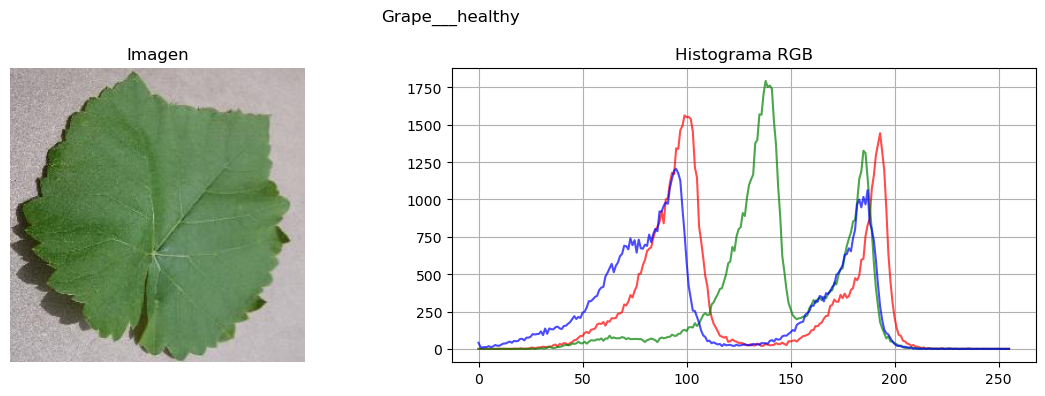

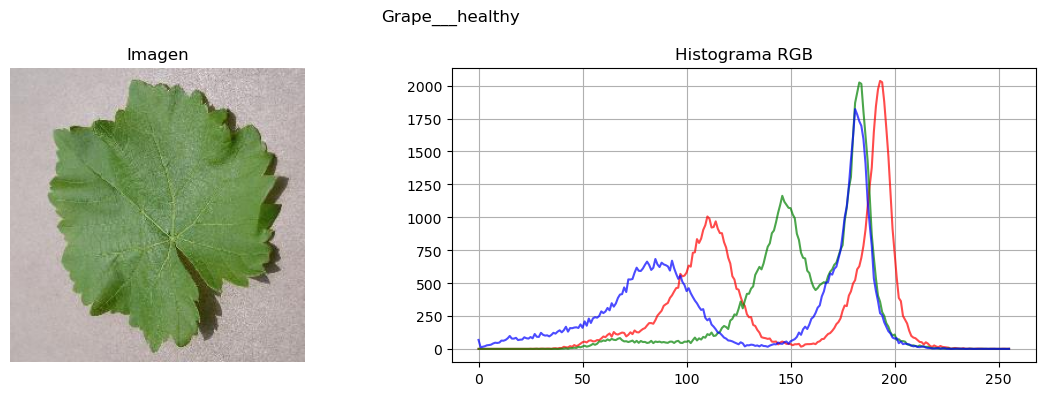

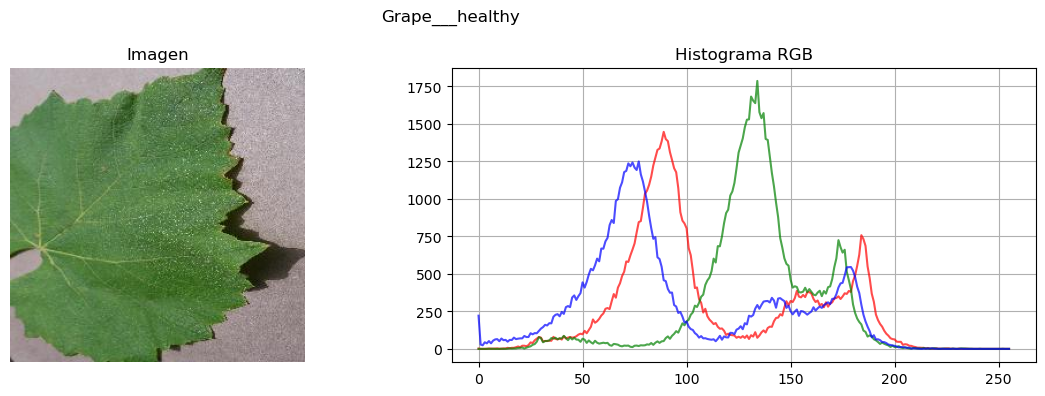

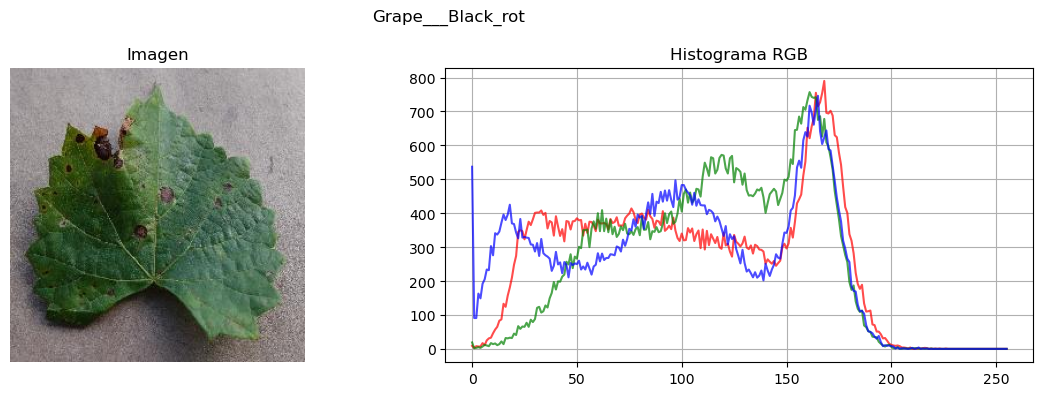

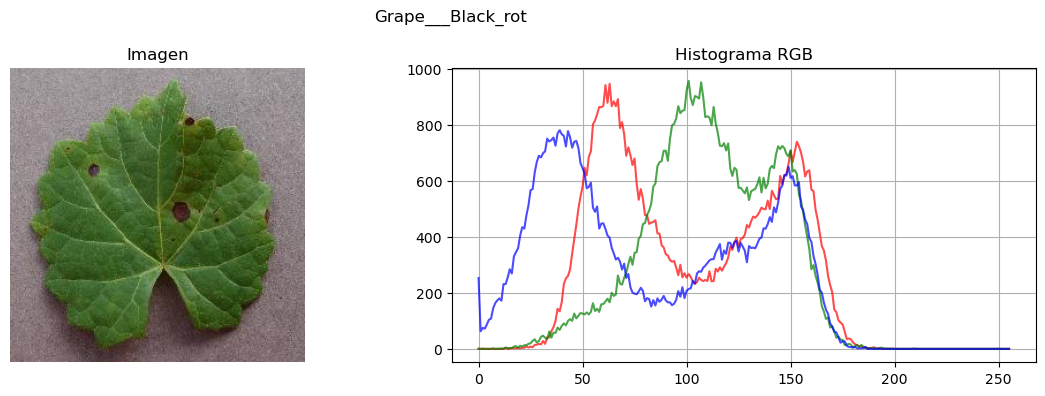

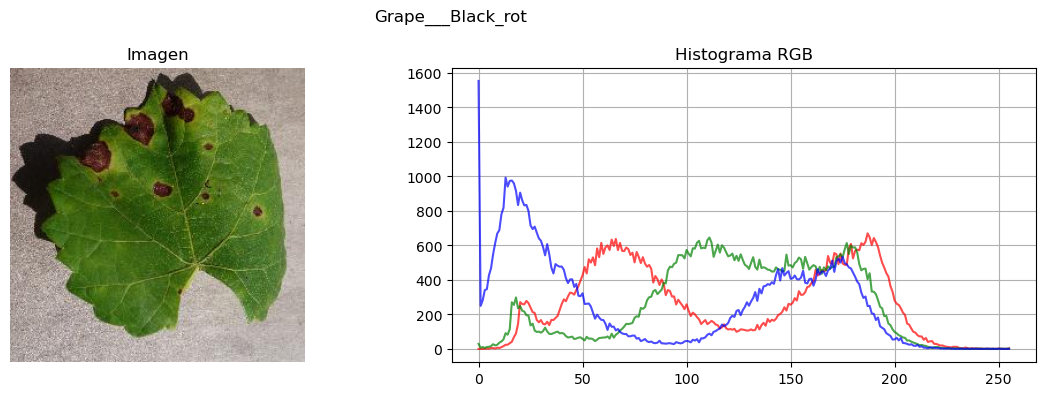

In [21]:
# Función para mostrar las imágenes y sus histogramas
def analizar_rgb(imagen_path, titulo):
    img = cv2.imread(imagen_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Mostrar imagen
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen')
    
    # Mostrar histograma de color
    for i, color in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ax2.plot(hist, color=color, alpha=0.7)
    ax2.set_title('Histograma RGB')
    ax2.grid(True)
    
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()
    
# Seleccionamos 3 imágenes aleatorias
for clase in ['Grape___healthy', 'Grape___Black_rot']:
    
    muestras = np.random.choice(os.listdir(os.path.join(base_path, clase)), 3)
    
    for img_name in muestras:
        img_path = os.path.join(base_path, clase, img_name)
        analizar_rgb(img_path, clase)

Se puede ver como principal diferencia entre las imágenes de ambas clases que en las imágenes de hojas con Black Rot hay un aumento en los valores en las frecuencias entre 0 y 50, que es donde están los colores de los puntos marrones que caracterizan a la enfermedad. Comparando con las imágenes de las hojas sanas los valores en esa banda son casi nulos y probablemente se deban al suelo de fondo.

Ahora vamos a analizar los histogramas RGB promedio de 50 imágenes de cada clase para obtener una visión más general de este fenómeno, será útil para confirmar la intuición que tuvimos antes:

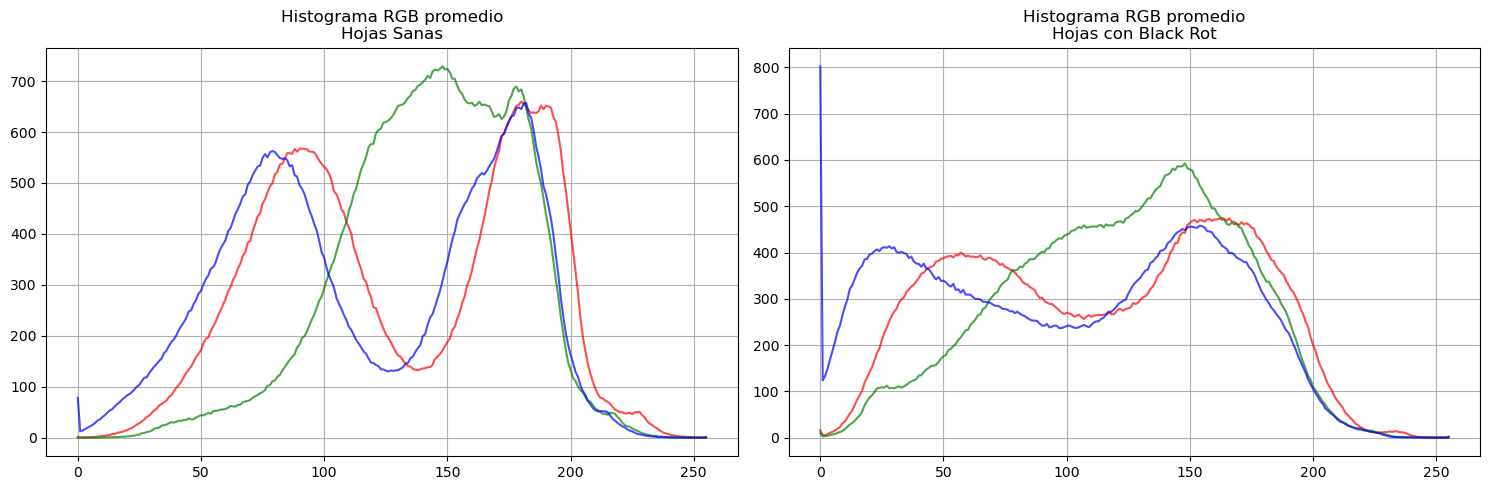

In [27]:
# Tomamos 50 imágenes aleatorias de cada clase
healthy_samples = np.random.choice(healthy_dt, 50)
black_rot_samples = np.random.choice(black_rot_dt, 50)

# Inicializamos arrays para acumular histogramas
healthy_hist = np.zeros((3, 256))
black_rot_hist = np.zeros((3, 256))

# Histogramas promedio para hojas sanas
for img_name in healthy_samples:
    img = cv2.imread(os.path.join(base_path, "Grape___healthy", img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(3):
        healthy_hist[i] += cv2.calcHist([img], [i], None, [256], [0, 256])[:,0]
healthy_hist /= 50

# Histogramas promedio para hojas con black rot
for img_name in black_rot_samples:
    img = cv2.imread(os.path.join(base_path, "Grape___Black_rot", img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(3):
        black_rot_hist[i] += cv2.calcHist([img], [i], None, [256], [0, 256])[:,0]
black_rot_hist /= 50

# Graficamos los histogramas promedio
plt.figure(figsize=(15, 5))
colors = ['red', 'green', 'blue']

plt.subplot(1, 2, 1)
for i, color in enumerate(colors):
    plt.plot(healthy_hist[i], color=color, alpha=0.7)
plt.title('Histograma RGB promedio\nHojas Sanas')
plt.grid(True)

plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    plt.plot(black_rot_hist[i], color=color, alpha=0.7)
plt.title('Histograma RGB promedio\nHojas con Black Rot')
plt.grid(True)

plt.tight_layout()
plt.show()

Se confirma el fenómeno encontrado de una manera más tajante. Cabe destacar que el pico cercano a la frecuencia 0 de las imágenes de las hojas con Black Rot lo atribuímos a que esas imágenes se tomaron en un momento del día donde las hojas creaban una sombra sobre la superficie donde fueron colocadas, no tiene que ver con la enfermedad de la hoja. 

#### f. Análisis de brillo

Analizaremos la distribución del brillo (intensidad promedio) de las imágenes para cada clase mediante un boxplot. Esto nos ayudará a determinar si las hojas enfermas tienden a ser más oscuras que las sanas.

C:\Users\matim\AppData\Local\Temp\ipykernel_17616\3980069984.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([brillo_healthy, brillo_blackrot], labels=['Hojas Sanas', 'Hojas con Black Rot'])


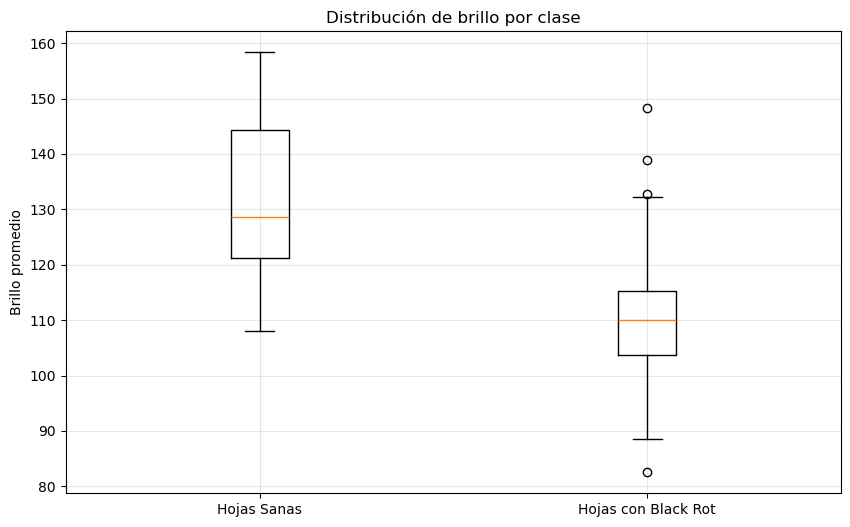

Estadísticas de brillo:
Hojas sanas - Media: 131.21, Std: 13.37
Hojas con Black Rot - Media: 110.39, Std: 12.61


In [ ]:
# Calculamos brillo promedio para 50 imágenes de cada clase
n_muestras = 50
brillo_healthy = []
brillo_blackrot = []

# Muestras aleatorias
healthy_samples = np.random.choice(healthy_dt, n_muestras)
black_rot_samples = np.random.choice(black_rot_dt, n_muestras)

# Calcular brillo promedio para cada imagen
for img_name in healthy_samples:
    img = cv2.imread(os.path.join(base_path, "Grape___healthy", img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    brillo_healthy.append(np.mean(img))
    
for img_name in black_rot_samples:
    img = cv2.imread(os.path.join(base_path, "Grape___Black_rot", img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    brillo_blackrot.append(np.mean(img))

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([brillo_healthy, brillo_blackrot], labels=['Hojas Sanas', 'Hojas con Black Rot'])
plt.title('Distribución de brillo por clase')
plt.ylabel('Brillo promedio')
plt.grid(True, alpha=0.3)
plt.show()


print("Estadísticas de brillo:")
print(f"Hojas sanas - Media: {np.mean(brillo_healthy):.2f}, Std: {np.std(brillo_healthy):.2f}")
print(f"Hojas con Black Rot - Media: {np.mean(brillo_blackrot):.2f}, Std: {np.std(brillo_blackrot):.2f}")

El análisis de brillo promedio muestra una diefrencia clara entre ambas clases: las hojas sanas presentan valores de brillo más altos y con mayor dispersión, mientras que las hojas con Black Rot tienden a ser más oscuras y con menor variabilidad. Esto coincide con la presencia de manchas marrones en la clase enferma.

Igual es evidente que las imágenes de hojas sanas parecen haber sido tomadas en un momento del día más soleado. Esto introduce un sesgo de iluminación que podría afectar al modelo, ya que el brillo pasaría a ser una pista indirecta de la clase en lugar de los patrones de la enfermedad.

Para compensar esta diferencia en el entrenamiento será necesario aplicar técnicas de normalización y data augmentation, como:

-Ajustes de brillo y contraste aleatorios en ambas clases.

-Normalización de valores de píxeles para reducir la influencia de la iluminación.

-Aumentar artificialmente las imágenes de la clase minoritaria (healthy) con variaciones de iluminación, rotación y escalado, evitando que el modelo dependa únicamente del brillo para clasificar.